# Playground for testing neural network acquisition optimization

In [1]:
%matplotlib inline
from functools import partial
import os
import sys
import GPyOpt
import numpy as np
from shinyutils.matwrap import MatWrap as mw
from tensorboardX import SummaryWriter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#from infopt.ihvp import LowRankIHVP
from infopt.nnacq import NNAcq
from infopt.nnmodel import NNModel
from infopt.nrmodel import NRModel
from exputils.models import NRNet

LDA = 1e-2

## Network used to model data

## Objective function

In [2]:
f_true = GPyOpt.objective_examples.experiments1d.forrester(sd=0)
f_noisy = GPyOpt.objective_examples.experiments1d.forrester(sd=1)
bounds = [{"name": "var_1", "type": "continuous", "domain": (0, 1)}]
f_min = f_true.fmin

## Optimization setup

In [3]:
log_path = "logs/nr_acq_play"
tb_writer = SummaryWriter(log_path)

net = NRNet(num_layers=3, in_dim=1, hidden_dim=4, nonlin=torch.tanh, has_bias=True, init_as_design=True)
net_optim = optim.Adam(net.parameters(), lr=0.05)
nr_model = NRModel(
    net,
    lda=LDA,
    optim=net_optim,
    update_batch_size=np.inf,
    update_iters_per_point=10,
    tb_writer=tb_writer,
)

objective = GPyOpt.core.task.SingleObjective(f_noisy.f)
space = GPyOpt.Design_space(space=bounds)
initial_design = GPyOpt.experiment_design.initial_design("random", space, 5)
acq = NNAcq(
    nr_model,
    space,
    exploration_weight=2,
    tb_writer=tb_writer,
    optim_cls=optim.Adam,
    optim_kwargs={"lr": 0.01},
    optim_iters=100,
)
# acq_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)
# acq = GPyOpt.acquisitions.AcquisitionLCB(nr_model, space, acq_optimizer,
#                                          exploration_weight=2)
feval = GPyOpt.core.evaluators.Sequential(acq)
nr_bo = GPyOpt.methods.ModularBayesianOptimization(
    nr_model, space, objective, acq, feval, initial_design, normalize_Y=True
)

nr_bo.Y, _ = nr_bo.objective.evaluate(nr_bo.X)
nr_bo.num_acquisitions = 0
nr_bo.model_parameters_iterations = None
nr_bo.context = None

X_te = np.linspace(0, 1, 100)[:, np.newaxis]
Y_te = f_true.f(X_te)

## Single optimization step

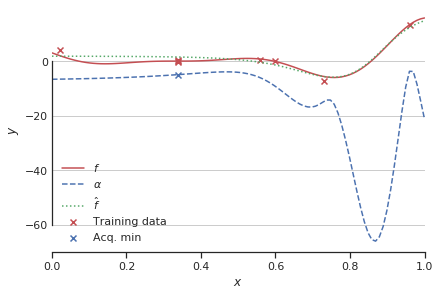

In [12]:
nr_bo._update_model(nr_bo.normalization_type)
nr_bo.suggested_sample = nr_bo._compute_next_evaluations()
nr_bo.X = np.vstack((nr_bo.X, nr_bo.suggested_sample))
nr_bo.evaluate_objective()

M_te, S_te = nr_model.predict(X_te)

# Undo normalization
mu, sig = float(nr_bo.Y.mean()), float(nr_bo.Y.std())
if sig > 0:
    M_te = sig * M_te
    S_te = sig * S_te
M_te = M_te + mu

# Compute acquisition function values
A_te = M_te - acq.exploration_weight * S_te

acq_xmin = nr_bo.suggested_sample
acq_fmin = A_te[np.argmin(np.abs(X_te - acq_xmin))]

mw.configure(context="notebook", backend="macosx")
fig = mw.plt().figure()
ax = fig.add_subplot(111)
ax.plot(X_te[:, 0], Y_te[:, 0], label="$f$", color="r")
ax.scatter(nr_bo.X[:, 0], nr_bo.Y[:, 0], color="r", marker="x", label="Training data")
ax.plot(X_te[:, 0], A_te[:, 0], color="b", linestyle="--", label="$\\alpha$")
ax.plot(X_te[:, 0], M_te[:, 0], color="g", linestyle=":", label="$\\hat{f}$")
ax.scatter(acq_xmin, acq_fmin, color="b", marker="x", label="Acq. min")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_xlim(0, 1)
ax.legend()
mw.sns().despine(fig=fig, ax=ax, trim=True)

In [13]:
print(nr_bo.X.shape)
print(acq.x)

(8, 1)
tensor([[0.3379]], requires_grad=True)


In [14]:
list(acq.model.net.parameters())

[Parameter containing:
 tensor([[ 0.2060],
         [ 2.0159],
         [-0.2060],
         [-2.0159]], requires_grad=True),
 Parameter containing:
 tensor([ 0.1528, -1.6149, -0.1528,  1.6149], requires_grad=True),
 Parameter containing:
 tensor([[ 0.2169, -2.6808,  0.8330,  2.0299],
         [-0.4347,  2.4089, -0.3246, -1.0304],
         [ 0.8330,  2.0299,  0.2169, -2.6808],
         [-0.3246, -1.0304, -0.4347,  2.4089]], requires_grad=True),
 Parameter containing:
 tensor([ 0.9682,  0.7736, -0.9682, -0.7736], requires_grad=True),
 Parameter containing:
 tensor([[-1.4391, -0.6871,  1.4391,  0.6871]], requires_grad=True),
 Parameter containing:
 tensor([1.6160], requires_grad=True)]

In [15]:
acq.model.Z_inv

tensor([[78.8334, -4.4373, 21.1666,  ..., -0.7897, -3.2034,  5.6103],
        [-4.4373, 64.1678,  4.4373,  ..., -6.2732, -3.4648, -5.1199],
        [21.1666,  4.4373, 78.8334,  ...,  0.7897,  3.2035, -5.6103],
        ...,
        [-0.7897, -6.2732,  0.7897,  ..., 57.8157,  4.0917,  7.6848],
        [-3.2034, -3.4648,  3.2035,  ...,  4.0917, 54.9983, -1.5681],
        [ 5.6103, -5.1199, -5.6103,  ...,  7.6848, -1.5681, 19.3905]])